In [2]:
import torch
from torch import Tensor
print(torch.__version__)

2.0.1


In [3]:
# Install required packages.
import os
os.environ['TORCH'] = torch.__version__

!pip3 install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip3 install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip3 install pyg-lib -f https://data.pyg.org/whl/nightly/torch-${TORCH}.html
!pip3 install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in links: https://data.pyg.org/whl/torch-2.0.1.html
Looking in links: https://data.pyg.org/whl/torch-2.0.1.html
Looking in links: https://data.pyg.org/whl/nightly/torch-2.0.1.html
ERROR: Could not find a version that satisfies the requirement pyg-lib (from versions: none)
ERROR: No matching distribution found for pyg-lib
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /private/var/folders/nz/0trbh9kx61d_rsf7yfgbt3gc0000gn/T/pip-req-build-484ivrz6
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /private/var/folders/nz/0trbh9kx61d_rsf7yfgbt3gc0000gn/T/pip-req-build-484ivrz6
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 999af2312efcdd7bd35e40c9b21c4a6a45464ac5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Heterogeneous Graph Creation

First, we download the dataset to an arbitrary folder (in this case, the current directory):

### Data

In [4]:
import pandas as pd

df1=pd.read_csv('../data/product_detail_fin.csv')
df2=pd.read_csv('../data/ppv_encrypted-001.csv', nrows=100000)

print('products.csv:')
print('===========')
print(df1.head())
print()
print('count.csv:')
print('============')
print(df2.head())

products.csv:
      product_id        price cms_vertical
0  9780000018885   690.000000         book
1  9780002245708  2665.000000         book
2  9780007154692   333.000000         book
3  9780007175185   192.222222         book
4  9780007216161   395.000000         book

count.csv:
         product_id  count                    account_id_enc
0  ACCG2DHTPQRPV4ZP      3  36ee6d3cd4e30b41e7b6aba58641e09a
1  ACCG57P5RGWJZARH     13  36ee6d3cd4e30b41e7b6aba58641e09a
2  MOBFUSBNAZGY7HQU     16  36ee6d3cd4e30b41e7b6aba58641e09a
3  ACCFHYJ8ZU9WDHDW      1  36ee6d3cd4e30b41e7b6aba58641e09a
4  ACNGFVMJ5ZKZVFDS      2  36ee6d3cd4e30b41e7b6aba58641e09a


In [5]:
df3=df1.merge(df2,how='inner',on='product_id')

In [6]:
frequency_map = df3['cms_vertical'].value_counts().to_dict()
# Map the frequency values to the original column
df3['cms_vertical'] = df3['cms_vertical'].map(frequency_map)

In [7]:
# dropping rows with high cms and price
df3 = df3[df3['cms_vertical'] < 600]
df3 = df3[df3['price'] < 3000]
df3=df3.sample(frac=1).reset_index(drop=True)
df3

,product_id,price,cms_vertical,count,account_id_enc
0,HSYF42FFEHZUJZBP,335.121838,80,2,056b89f05f4b160991cd101b906f87f9
1,PEND8QGTFHCZR2ZW,346.726268,368,1,e03513938449f4df633637854f391d8c
2,BPRFDXDUC3Y9GB7H,247.791736,17,1,3e3f6c69bdb0cfa2156481120a5e9354
3,SBNG3KSFFPVRPN2F,2134.210396,224,2,9d9b4534966a643b16f9cbc54150f021
4,TBRFUQSSVXPUBQH7,230.632948,2,1,bd12484f5c6969f344f2b3706a8efff6
...,...,...,...,...,...
44108,BRAFBB54UNHNXPQM,304.435754,377,1,9123df36ddc2221ed7fd8af470dd9d0b
44109,FANDXH7GJXZYMHUG,2434.885607,373,1,2348408a304afc45e49a26183aa58d89
44110,CPHE9NNAZGKA8GHT,154.126450,37,1,08488bbdee624eb956183e62595b7f17
44111,LSKG4XQ3E8UD5GYH,149.482051,252,1,ff8b130ffa8cf03282a459d08341d02f


### Normalise and freq encoding

In [8]:
min_val = df3['count'].min()
max_val = df3['count'].max()
df3['count'] = (df3['count'] - min_val) / (max_val - min_val)
min_val = df3['price'].min()
max_val = df3['price'].max()
df3['price'] = (df3['price'] - min_val) / (max_val - min_val)

In [9]:
# User features
mean_rating = df2.groupby("account_id_enc")["count"].mean().rename("mean")
num_rating = df2.groupby("account_id_enc")["product_id"].count().rename("total")

In [10]:
df3

,product_id,price,cms_vertical,count,account_id_enc
0,HSYF42FFEHZUJZBP,0.111528,80,0.008333,056b89f05f4b160991cd101b906f87f9
1,PEND8QGTFHCZR2ZW,0.115409,368,0.000000,e03513938449f4df633637854f391d8c
2,BPRFDXDUC3Y9GB7H,0.082318,17,0.000000,3e3f6c69bdb0cfa2156481120a5e9354
3,SBNG3KSFFPVRPN2F,0.713281,224,0.008333,9d9b4534966a643b16f9cbc54150f021
4,TBRFUQSSVXPUBQH7,0.076579,2,0.000000,bd12484f5c6969f344f2b3706a8efff6
...,...,...,...,...,...
44108,BRAFBB54UNHNXPQM,0.101264,377,0.000000,9123df36ddc2221ed7fd8af470dd9d0b
44109,FANDXH7GJXZYMHUG,0.813850,373,0.000000,2348408a304afc45e49a26183aa58d89
44110,CPHE9NNAZGKA8GHT,0.050989,37,0.000000,08488bbdee624eb956183e62595b7f17
44111,LSKG4XQ3E8UD5GYH,0.049436,252,0.000000,ff8b130ffa8cf03282a459d08341d02f


### Dicts and ids

In [11]:
import numpy as np
product_ids = np.unique(df3['product_id'])
user_ids = np.unique(df3['account_id_enc'])
product_dict = {}
user_dict = {}
for i in range(len(product_ids)):
    product_dict[product_ids[i]] = i 
for i in range(len(user_ids)):
    user_dict[user_ids[i]] = i

In [12]:
user_dict

{'001c11387163b3efd1e054b53b45a089': 0,
 '004c635f008509b7c1552c54e51e8c8e': 1,
 '007bab6a45de82f54e81d22e9176a375': 2,
 '00823dd4a9edfea5b59e9f0c5f46b2cb': 3,
 '00843ab6e84044d8144fd6719c5d044c': 4,
 '009758cf3b5495e81fd454e8761f7d2d': 5,
 '009b18068ca8def45152efd86a519a6f': 6,
 '00ce12d76d1d7fdac0a6341c2f3e6307': 7,
 '00ea051ea6f7c4df1ba76d26c77ae3a8': 8,
 '00f0ab351a2e6b0534e2c1688b3b962b': 9,
 '0102da73dc62272bd19e52cf4284cc6e': 10,
 '011e047cc5a350d9b469b8d648c39b88': 11,
 '013d657e5cce089f01c9508a5338a8a0': 12,
 '0147bb989d530571b892046d03e06a92': 13,
 '0149fbaeb08536f80b655f8e4b118b4c': 14,
 '0152f30515fe0b9be59a432c0d722341': 15,
 '01593490bfd42ffe38eff99812e05e65': 16,
 '0171875ac16b7694e58b5b923f22d15f': 17,
 '017a76d5691ed07ebac287692453d343': 18,
 '01851d3a1cf0362dcc608ccb7065a1a8': 19,
 '019259cc359ba9cf780ce77965be5187': 20,
 '022176cfc442245a757f0c569ef5e2c9': 21,
 '026037520872fbff2c3ca87e41105be1': 22,
 '02664c7538d6f3e81fbfc6bc2c7af048': 23,
 '027d35826dbd1ee89cef9512

In [13]:
product_dict

{'9780008123208': 0,
 '9780008386597': 1,
 '9780062312686': 2,
 '9780062641540': 3,
 '9780071074827': 4,
 '9780099572862': 5,
 '9780143028574': 6,
 '9780143062226': 7,
 '9780143333166': 8,
 '9780143424123': 9,
 '9780143424680': 10,
 '9780143442295': 11,
 '9780143442950': 12,
 '9780143442974': 13,
 '9780143446248': 14,
 '9780143450832': 15,
 '9780143452676': 16,
 '9780143453635': 17,
 '9780190123659': 18,
 '9780195628166': 19,
 '9780195687859': 20,
 '9780198075554': 21,
 '9780198076407': 22,
 '9780199472222': 23,
 '9780670093250': 24,
 '9781408855652': 25,
 '9781409303183': 26,
 '9781444775815': 27,
 '9781542040464': 28,
 '9781542094139': 29,
 '9781612680194': 30,
 '9781786330895': 31,
 '9781847941831': 32,
 '9786273549903': 33,
 '9788121905510': 34,
 '9788121924405': 35,
 '9788121924986': 36,
 '9788129118929': 37,
 '9788129135513': 38,
 '9788129142146': 39,
 '9788129142153': 40,
 '9788131017746': 41,
 '9788131251430': 42,
 '9788171673407': 43,
 '9788172234881': 44,
 '9788172234980': 45

### Node features and Edge list

In [14]:
## Maps for edges and id encoding
s=[]
t=[]
e_wt=[]
edge_list = [[], []]

# create empty features 2d array of size (total_nodes, feature dim)
for index,row in df3.iterrows():
    prod_feat_len = len(df3.iloc[index].drop(['product_id','account_id_enc','count']).to_numpy())
    break
    
user_nodes = len(user_dict)
prod_nodes = len(product_dict)
prod_feat_len = 64
user_feat_len = 64

user_features = np.empty(shape=(user_nodes,prod_feat_len))
prod_features = np.empty(shape=(prod_nodes,prod_feat_len))

for index,row in df3.iterrows():
    prod_id=row['product_id']
    user_id=row['account_id_enc']
    e_wt.append([float(row['count'])])
    user_index = user_dict[user_id]
    prod_index = product_dict[prod_id]

    s.append(user_dict[user_id])
    t.append(product_dict[prod_id])
    edge_list[0].append(user_index)
    edge_list[1].append(prod_index)

    # node_features[prod_index] = ohe.iloc[index].drop(['product_id','account_id_enc','count']).to_numpy()
    u=np.array([mean_rating[user_id], num_rating[user_id]])
    padded_u = np.pad(u, (0, 62), mode='constant')
    p = df3.iloc[index].drop(['product_id','account_id_enc','count']).to_numpy()
    padded_p = np.pad(p, (0, 62), mode='constant')
    # padded_u = u
    user_features[user_index] = padded_u
    prod_features[prod_index] = padded_p

In [15]:
edge_list = torch.tensor(edge_list, dtype=int)

In [16]:
edge_list.shape

torch.Size([2, 44113])

In [17]:
e_wt = torch.tensor(e_wt, dtype=float).to(torch.double)
e_wt.shape

torch.Size([44113, 1])

In [18]:
prod_features = torch.tensor(prod_features, dtype=float, requires_grad=True).to(torch.double)
prod_features.shape

torch.Size([19533, 64])

In [19]:
user_features = torch.tensor(user_features, dtype=float, requires_grad=True).to(torch.double)
user_features.shape

torch.Size([2973, 64])

In [20]:
print(user_nodes)
print(prod_nodes)

2973
19533


In [21]:
e_wt.shape

torch.Size([44113, 1])

### PyG hetergenous Dataset

In [22]:
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T

data = HeteroData()

# Save node indices:
data["user"].node_id = torch.arange(len(user_ids), dtype=int)
data["product"].node_id = torch.arange(len(product_ids), dtype=int)

# Add the node features and edge indices:
data["product"].x = prod_features.to(torch.double)
data["user"].x = user_features.to(torch.double)
data["user", "views", "product"].edge_index = edge_list.to(torch.long)
data["user", "views", "product"].edge_attr = e_wt.to(torch.double)

# We also need to make sure to add the reverse edges from movies to users
# in order to let a GNN be able to pass messages in both directions.
# We can leverage the `T.ToUndirected()` transform for this from PyG:
data = T.ToUndirected()(data)

print(data)

assert data.node_types == ["user", "product"]
assert data.edge_types == [("user", "views", "product"),
                           ("product", "rev_views", "user")]
assert data["user"].num_nodes == 15
assert data["user"].num_features == 64
assert data["product"].num_nodes == 471
assert data["product"].num_features == 64
data["user", "views", "product"].num_edge_features == 1
assert data["user", "views", "product"].num_edges == 500
assert data["product", "rev_views", "user"].num_edges == 500

HeteroData(
  user={
    node_id=[2973],
    x=[2973, 64],
  },
  product={
    node_id=[19533],
    x=[19533, 64],
  },
  (user, views, product)={
    edge_index=[2, 44113],
    edge_attr=[44113, 1],
  },
  (product, rev_views, user)={
    edge_index=[2, 44113],
    edge_attr=[44113, 1],
  }
)


AssertionError: 

In [23]:
data["user", "views", "product"].num_edge_features

1

## Defining Edge-level Training Splits

Since our data is now ready-to-be-used, we can split the ratings of users into training, validation, and test splits.
This is needed in order to ensure that we leak no information about edges used during evaluation into the training phase.
For this, we make use of the [`transforms.RandomLinkSplit`](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.RandomLinkSplit) transformation from PyG.
This transforms randomly divides the edges in the `("user", "rates", "movie")` into training, validation and test edges.
The `disjoint_train_ratio` parameter further separates edges in the training split into edges used for message passing (`edge_index`) and edges used for supervision (`edge_label_index`).
Note that we also need to specify the reverse edge type `("movie", "rev_rates", "user")`.
This allows the `RandomLinkSplit` transform to drop reverse edges accordingly to not leak any information into the training phase.

In [24]:
# For this, we first split the set of edges into
# training (80%), validation (10%), and testing edges (10%).
# Across the training edges, we use 70% of edges for message passing,
# and 30% of edges for supervision.
# We further want to generate fixed negative edges for evaluation with a ratio of 2:1.
# Negative edges during training will be generated on-the-fly.
# We can leverage the `RandomLinkSplit()` transform for this from PyG:
transform = T.RandomLinkSplit(
    num_val=0.01,
    num_test=0.01,
    disjoint_train_ratio=0.3,
    neg_sampling_ratio=2.0,
    add_negative_train_samples=False,
    edge_types=("user", "views", "product"),
    rev_edge_types=("product", "rev_views", "user"),
)

train_data, val_data, test_data = transform(data)
print("Training data:")
print("==============")
print(train_data)
print()
print("Validation data:")
print("================")
print(val_data)

print("Test data:")
print("================")
print(test_data)

assert train_data["user", "views", "product"].num_edges == 56469
assert train_data["user", "views", "product"].edge_label_index.size(1) == 24201
assert train_data["product", "rev_views", "user"].num_edges == 56469
# No negative edges added:
assert train_data["user", "views", "product"].edge_label.min() == 1
assert train_data["user", "views", "product"].edge_label.max() == 1

assert val_data["user", "views", "product"].num_edges == 80670
assert val_data["user", "views", "product"].edge_label_index.size(1) == 30249
assert val_data["product", "rev_views", "user"].num_edges == 80670
# Negative edges with ratio 2:1:
assert val_data["user", "views", "proudct"].edge_label.long().bincount().tolist() == [20166, 10083]

Training data:
HeteroData(
  user={
    node_id=[2973],
    x=[2973, 64],
  },
  product={
    node_id=[19533],
    x=[19533, 64],
  },
  (user, views, product)={
    edge_index=[2, 30262],
    edge_attr=[30262, 1],
    edge_label=[12969],
    edge_label_index=[2, 12969],
  },
  (product, rev_views, user)={
    edge_index=[2, 30262],
    edge_attr=[30262, 1],
  }
)

Validation data:
HeteroData(
  user={
    node_id=[2973],
    x=[2973, 64],
  },
  product={
    node_id=[19533],
    x=[19533, 64],
  },
  (user, views, product)={
    edge_index=[2, 43231],
    edge_attr=[43231, 1],
    edge_label=[1323],
    edge_label_index=[2, 1323],
  },
  (product, rev_views, user)={
    edge_index=[2, 43231],
    edge_attr=[43231, 1],
  }
)
Test data:
HeteroData(
  user={
    node_id=[2973],
    x=[2973, 64],
  },
  product={
    node_id=[19533],
    x=[19533, 64],
  },
  (user, views, product)={
    edge_index=[2, 43672],
    edge_attr=[43672, 1],
    edge_label=[1323],
    edge_label_index=[2, 132

AssertionError: 

In [25]:
train_data['product'].x.shape

torch.Size([19533, 64])

## Defining Mini-batch Loaders

We are now ready to create a mini-batch loader that will generate subgraphs that can be used as input into our GNN.
While this step is not strictly necessary for small-scale graphs, it is absolutely necessary to apply GNNs on larger graphs that do not fit onto GPU memory otherwise.
Here, we make use of the [`loader.LinkNeighborLoader`](https://pytorch-geometric.readthedocs.io/en/latest/modules/loader.html#torch_geometric.loader.LinkNeighborLoader) which samples multiple hops from both ends of a link and creates a subgraph from it.
Here, `edge_label_index` serves as the "seed links" to start sampling from.

In [26]:
(train_data["user", "views", "product"].edge_label.shape)

torch.Size([12969])

In [27]:
# In the first hop, we sample at most 20 neighbors.
# In the second hop, we sample at most 10 neighbors.
# In addition, during training, we want to sample negative edges on-the-fly with
# a ratio of 2:1.
# We can make use of the `loader.LinkNeighborLoader` from PyG:
from torch_geometric.loader import LinkNeighborLoader

# Define seed edges:
edge_label_index = train_data["user", "views", "product"].edge_label_index
edge_label = train_data["user", "views", "product"].edge_label
edge_attr = train_data["user", "views", "product"].edge_attr

train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[20,10],
    neg_sampling_ratio=2.0,
    edge_label_index=(("user", "views", "product"), edge_label_index),
    edge_label=edge_label,
    # weight_attr=edge_attr,
    batch_size=2048,
    shuffle=True,
)

# Inspect a sample:
sampled_data = next(iter(train_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data)

assert sampled_data["user", "views", "product"].edge_label_index.size(1) == 3 * 128
assert sampled_data["user", "views", "product"].edge_label.min() == 0
assert sampled_data["user", "views", "product"].edge_label.max() == 1

Sampled mini-batch:
HeteroData(
  user={
    node_id=[2890],
    x=[2890, 64],
    n_id=[2890],
  },
  product={
    node_id=[14545],
    x=[14545, 64],
    n_id=[14545],
  },
  (user, views, product)={
    edge_index=[2, 26745],
    edge_attr=[26745, 1],
    edge_label=[6144],
    edge_label_index=[2, 6144],
    e_id=[26745],
    input_id=[2048],
  },
  (product, rev_views, user)={
    edge_index=[2, 21952],
    edge_attr=[21952, 1],
    e_id=[21952],
  }
)


AssertionError: 

## Creating a Heterogeneous Link-level GNN

We are now ready to create our heterogeneous GNN.
The GNN is responsible for learning enriched node representations from the surrounding subgraphs, which can be then used to derive edge-level predictions.
For defining our heterogenous GNN, we make use of [`nn.SAGEConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.SAGEConv) and the [`nn.to_hetero()`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.to_hetero_transformer.to_hetero) function, which transforms a GNN defined on homogeneous graphs to be applied on heterogeneous ones.

In addition, we define a final link-level classifier, which simply takes both node embeddings of the link we are trying to predict, and applies a dot-product on them.

As users do not have any node-level information, we choose to learn their features jointly via a `torch.nn.Embedding` layer. In order to improve the expressiveness of movie features, we do the same for movie nodes, and simply add their shallow embeddings to the pre-defined genre features.

In [28]:
!pip3 install --upgrade torch-geometric

In [29]:
from torch_geometric.nn import SAGEConv, to_hetero, GATConv
import torch.nn.functional as F

NUM_EDGE_FEATURES=1

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()

        self.conv1 = GATConv(hidden_channels, hidden_channels, edge_dim = NUM_EDGE_FEATURES, add_self_loops=False).to(torch.double)
        self.conv2 = GATConv(hidden_channels, hidden_channels, edge_dim = NUM_EDGE_FEATURES, add_self_loops=False).to(torch.double)

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor) -> Tensor:
        x = F.relu(self.conv1(x, edge_index, edge_attr=edge_attr)).to(torch.double)
        x = self.conv2(x, edge_index, edge_attr=edge_attr).to(torch.double)
        return x

# Our final classifier applies the dot-product between source and destination
# node embeddings to derive edge-level predictions:
class Classifier(torch.nn.Module):
    def forward(self, x_user: Tensor, x_product: Tensor, edge_label_index: Tensor) -> Tensor:
        # Convert node embeddings to edge-level representations:
        edge_feat_user = x_user[edge_label_index[0]].to(torch.double)
        edge_feat_prod = x_product[edge_label_index[1]].to(torch.double)

        # Apply dot-product to get a prediction per supervision edge:
        return (edge_feat_user * edge_feat_prod).sum(dim=-1).to(torch.double)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        # Learn two embedding matrices for users and products:
        self.prod_lin = torch.nn.Linear(prod_feat_len, hidden_channels).to(torch.double)
        self.user_lin = torch.nn.Linear(user_feat_len, hidden_channels).to(torch.double)
        self.user_emb = torch.nn.Embedding(data["user"].num_nodes, hidden_channels).to(torch.double)
        self.prod_emb = torch.nn.Embedding(data["product"].num_nodes, hidden_channels).to(torch.double)

        # Instantiate homogeneous GNN:
        self.gnn = GNN(hidden_channels).to(torch.double)

        # Convert GNN model into a heterogeneous variant:
        self.gnn = to_hetero(self.gnn, metadata=data.metadata()).to(torch.double)

        self.classifier = Classifier().to(torch.double)

    def forward(self, data: HeteroData) -> Tensor:
        x_dict = {
          "user": self.user_lin(data["user"].x) + self.user_emb(data["user"].node_id.to(torch.long)),
          "product": self.prod_lin(data["product"].x) + self.prod_emb(data["product"].node_id.to(torch.long)),
        }
        # print(data["product"].x.shape)
        emb = x_dict

        x_dict['user']=x_dict['user'].to(torch.double)
        x_dict['product']=x_dict['product'].to(torch.double)
        
        # `x_dict` holds feature matrices of all node types
        # `edge_index_dict` holds all edge indices of all edge types
        x_dict_new = self.gnn(x_dict, data.edge_index_dict, data.edge_attr_dict)
        pred = self.classifier(
            x_dict_new["user"],
            x_dict_new["product"],
            data["user", "views", "product"].edge_label_index,
        )

        return pred, emb, data


model = Model(hidden_channels=128)
print(model)

Model(
  (prod_lin): Linear(in_features=64, out_features=128, bias=True)
  (user_lin): Linear(in_features=64, out_features=128, bias=True)
  (user_emb): Embedding(2973, 128)
  (prod_emb): Embedding(19533, 128)
  (gnn): GraphModule(
    (conv1): ModuleDict(
      (user__views__product): GATConv(128, 128, heads=1)
      (product__rev_views__user): GATConv(128, 128, heads=1)
    )
    (conv2): ModuleDict(
      (user__views__product): GATConv(128, 128, heads=1)
      (product__rev_views__user): GATConv(128, 128, heads=1)
    )
  )
  (classifier): Classifier()
)


## Training a Heterogeneous Link-level GNN

Training our GNN is then similar to training any PyTorch model.
We move the model to the desired device, and initialize an optimizer that takes care of adjusting model parameters via stochastic gradient descent.

The training loop then iterates over our mini-batches, applies the forward computation of the model, computes the loss from ground-truth labels and obtained predictions (here we make use of binary cross entropy), and adjusts model parameters via back-propagation and stochastic gradient descent.

In [30]:
from torch_geometric.utils import remove_self_loops
data["user", "views", "product"].edge_index, _ = remove_self_loops(data["user", "views", "product"].edge_index)
data["product", "rev_views", "user"].edge_index, _ = remove_self_loops(data["product", "rev_views", "user"].edge_index)

In [38]:
epochs=150

In [39]:
import tqdm
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

loss_arr = []
auc_arr = []

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
final_emb = {}
final_data = {}
for epoch in range(0, epochs):
    total_loss = total_examples = 0
    total_auc = 0
    for sampled_data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()

        sampled_data.to(device)
        pred, final_emb, final_data = model(sampled_data)

        ground_truth = sampled_data["user", "views", "product"].edge_label
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)
        auc = roc_auc_score(ground_truth.detach().numpy(), pred.detach().numpy())

        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_auc += float(auc) * pred.numel()
        total_examples += pred.numel()
    loss_arr.append(float(total_loss / total_examples))
    auc_arr.append(float(total_auc / total_examples))
    print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")

Device: 'cpu'


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.44it/s]


Epoch: 000, Loss: 2.6677


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.60it/s]


Epoch: 001, Loss: 1.5530


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.62it/s]


Epoch: 002, Loss: 1.0434


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.75it/s]


Epoch: 003, Loss: 0.8888


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.50it/s]


Epoch: 004, Loss: 0.8049


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.60it/s]


Epoch: 005, Loss: 0.7683


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.59it/s]


Epoch: 006, Loss: 0.7319


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.73it/s]


Epoch: 007, Loss: 0.7117


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.80it/s]


Epoch: 008, Loss: 0.6901


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.69it/s]


Epoch: 009, Loss: 0.6771


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.70it/s]


Epoch: 010, Loss: 0.6481


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.52it/s]


Epoch: 011, Loss: 0.6236


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.61it/s]


Epoch: 012, Loss: 0.5957


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.76it/s]


Epoch: 013, Loss: 0.5850


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.49it/s]


Epoch: 014, Loss: 0.5741


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.64it/s]


Epoch: 015, Loss: 0.5660


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.82it/s]


Epoch: 016, Loss: 0.5630


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.54it/s]


Epoch: 017, Loss: 0.5596


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.71it/s]


Epoch: 018, Loss: 0.5545


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.71it/s]


Epoch: 019, Loss: 0.5473


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.80it/s]


Epoch: 020, Loss: 0.5464


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.75it/s]


Epoch: 021, Loss: 0.5447


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.62it/s]


Epoch: 022, Loss: 0.5414


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.83it/s]


Epoch: 023, Loss: 0.5384


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.93it/s]


Epoch: 024, Loss: 0.5349


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.25it/s]


Epoch: 025, Loss: 0.5315


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.36it/s]


Epoch: 026, Loss: 0.5263


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.07it/s]


Epoch: 027, Loss: 0.5261


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.57it/s]


Epoch: 028, Loss: 0.5217


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.70it/s]


Epoch: 029, Loss: 0.5189


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.73it/s]


Epoch: 030, Loss: 0.5202


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.66it/s]


Epoch: 031, Loss: 0.5210


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.48it/s]


Epoch: 032, Loss: 0.5140


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.41it/s]


Epoch: 033, Loss: 0.5142


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.34it/s]


Epoch: 034, Loss: 0.5101


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.38it/s]


Epoch: 035, Loss: 0.5075


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.49it/s]


Epoch: 036, Loss: 0.5055


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.54it/s]


Epoch: 037, Loss: 0.5061


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.64it/s]


Epoch: 038, Loss: 0.4991


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.68it/s]


Epoch: 039, Loss: 0.4984


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.51it/s]


Epoch: 040, Loss: 0.4959


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.55it/s]


Epoch: 041, Loss: 0.4984


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.51it/s]


Epoch: 042, Loss: 0.4980


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.66it/s]


Epoch: 043, Loss: 0.4931


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.76it/s]


Epoch: 044, Loss: 0.4962


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.78it/s]


Epoch: 045, Loss: 0.4890


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.85it/s]


Epoch: 046, Loss: 0.4875


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.83it/s]


Epoch: 047, Loss: 0.4902


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.29it/s]


Epoch: 048, Loss: 0.4883


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.72it/s]


Epoch: 049, Loss: 0.4875


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.78it/s]


Epoch: 050, Loss: 0.4892


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.72it/s]


Epoch: 051, Loss: 0.4811


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.57it/s]


Epoch: 052, Loss: 0.4809


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.64it/s]


Epoch: 053, Loss: 0.4769


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.82it/s]


Epoch: 054, Loss: 0.4911


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.75it/s]


Epoch: 055, Loss: 0.4819


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.57it/s]


Epoch: 056, Loss: 0.4853


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.53it/s]


Epoch: 057, Loss: 0.4832


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.60it/s]


Epoch: 058, Loss: 0.4838


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.38it/s]


Epoch: 059, Loss: 0.4803


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.65it/s]


Epoch: 060, Loss: 0.4691


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.61it/s]


Epoch: 061, Loss: 0.4702


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.66it/s]


Epoch: 062, Loss: 0.4670


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.08it/s]


Epoch: 063, Loss: 0.4687


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.01it/s]


Epoch: 064, Loss: 0.4646


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.71it/s]


Epoch: 065, Loss: 0.4633


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.94it/s]


Epoch: 066, Loss: 0.4573


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.38it/s]


Epoch: 067, Loss: 0.4558


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.48it/s]


Epoch: 068, Loss: 0.4588


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.20it/s]


Epoch: 069, Loss: 0.4608


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.41it/s]


Epoch: 070, Loss: 0.4592


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.37it/s]


Epoch: 071, Loss: 0.4566


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.51it/s]


Epoch: 072, Loss: 0.4544


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.50it/s]


Epoch: 073, Loss: 0.4493


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.62it/s]


Epoch: 074, Loss: 0.4534


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.72it/s]


Epoch: 075, Loss: 0.4548


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.82it/s]


Epoch: 076, Loss: 0.4557


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.75it/s]


Epoch: 077, Loss: 0.4497


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.72it/s]


Epoch: 078, Loss: 0.4470


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.81it/s]


Epoch: 079, Loss: 0.4495


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.65it/s]


Epoch: 080, Loss: 0.4513


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.67it/s]


Epoch: 081, Loss: 0.4784


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.54it/s]


Epoch: 082, Loss: 0.4742


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.61it/s]


Epoch: 083, Loss: 0.4548


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.77it/s]


Epoch: 084, Loss: 0.4432


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.48it/s]


Epoch: 085, Loss: 0.4547


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.31it/s]


Epoch: 086, Loss: 0.4720


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.70it/s]


Epoch: 087, Loss: 0.4631


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.60it/s]


Epoch: 088, Loss: 0.4479


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.49it/s]


Epoch: 089, Loss: 0.4608


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.40it/s]


Epoch: 090, Loss: 0.4486


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.22it/s]


Epoch: 091, Loss: 0.4365


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.45it/s]


Epoch: 092, Loss: 0.4282


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.66it/s]


Epoch: 093, Loss: 0.4405


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.31it/s]


Epoch: 094, Loss: 0.4314


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.30it/s]


Epoch: 095, Loss: 0.4349


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.48it/s]


Epoch: 096, Loss: 0.4324


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.62it/s]


Epoch: 097, Loss: 0.4302


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.39it/s]


Epoch: 098, Loss: 0.4276


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.14it/s]


Epoch: 099, Loss: 0.4208


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.47it/s]


Epoch: 100, Loss: 0.4207


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.24it/s]


Epoch: 101, Loss: 0.4192


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.41it/s]


Epoch: 102, Loss: 0.4216


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.45it/s]


Epoch: 103, Loss: 0.4207


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.36it/s]


Epoch: 104, Loss: 0.4293


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.47it/s]


Epoch: 105, Loss: 0.4227


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.96it/s]


Epoch: 106, Loss: 0.4250


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.51it/s]


Epoch: 107, Loss: 0.4183


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.44it/s]


Epoch: 108, Loss: 0.4161


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.41it/s]


Epoch: 109, Loss: 0.4085


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.54it/s]


Epoch: 110, Loss: 0.4134


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.55it/s]


Epoch: 111, Loss: 0.4129


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.67it/s]


Epoch: 112, Loss: 0.4158


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.65it/s]


Epoch: 113, Loss: 0.4279


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.15it/s]


Epoch: 114, Loss: 0.4222


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.41it/s]


Epoch: 115, Loss: 0.4106


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.64it/s]


Epoch: 116, Loss: 0.4149


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.58it/s]


Epoch: 117, Loss: 0.4306


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.52it/s]


Epoch: 118, Loss: 0.4139


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.54it/s]


Epoch: 119, Loss: 0.4054


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.47it/s]


Epoch: 120, Loss: 0.4339


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.33it/s]


Epoch: 121, Loss: 0.4379


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.57it/s]


Epoch: 122, Loss: 0.4167


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.62it/s]


Epoch: 123, Loss: 0.4103


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.51it/s]


Epoch: 124, Loss: 0.4025


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.55it/s]


Epoch: 125, Loss: 0.4012


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.36it/s]


Epoch: 126, Loss: 0.3982


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.39it/s]


Epoch: 127, Loss: 0.3953


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.58it/s]


Epoch: 128, Loss: 0.3922


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.63it/s]


Epoch: 129, Loss: 0.3939


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.09it/s]


Epoch: 130, Loss: 0.3944


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.20it/s]


Epoch: 131, Loss: 0.3883


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.37it/s]


Epoch: 132, Loss: 0.3859


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.30it/s]


Epoch: 133, Loss: 0.3845


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.25it/s]


Epoch: 134, Loss: 0.3832


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.40it/s]


Epoch: 135, Loss: 0.3801


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.49it/s]


Epoch: 136, Loss: 0.3789


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.47it/s]


Epoch: 137, Loss: 0.3785


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.67it/s]


Epoch: 138, Loss: 0.3752


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.68it/s]


Epoch: 139, Loss: 0.3741


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.67it/s]


Epoch: 140, Loss: 0.3838


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.31it/s]


Epoch: 141, Loss: 0.3778


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.19it/s]


Epoch: 142, Loss: 0.3748


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.53it/s]


Epoch: 143, Loss: 0.3727


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.60it/s]


Epoch: 144, Loss: 0.3743


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.48it/s]


Epoch: 145, Loss: 0.3674


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.34it/s]


Epoch: 146, Loss: 0.3716


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.60it/s]


Epoch: 147, Loss: 0.3681


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.73it/s]


Epoch: 148, Loss: 0.3616


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.23it/s]

Epoch: 149, Loss: 0.3834


In [40]:
final_emb['product'].shape

torch.Size([11661, 128])

In [41]:
import matplotlib.pyplot as plt
def plot(arr, name):
    epochs_arr = np.arange(0, epochs)
    x = np.asarray(epochs_arr)
    ypoints = np.asarray(arr)
    plt.plot(x, ypoints)
    plt.xlabel("Epochs")
    plt.ylabel(name)
    plt.legend()
    plt.show()

In [42]:
type(loss_arr[0])

float

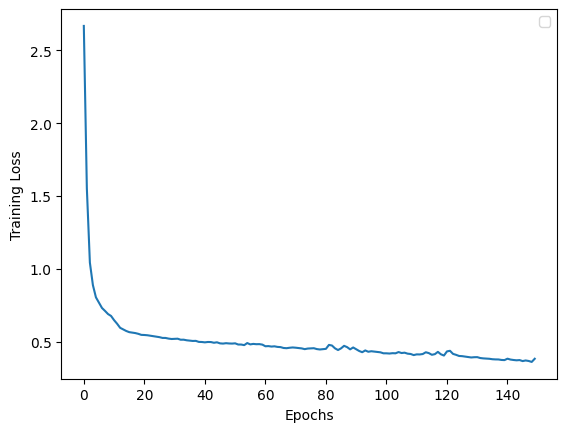

In [43]:
plot(loss_arr, 'Training Loss')

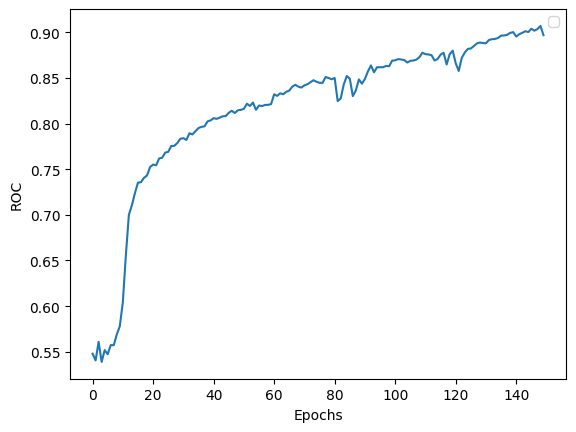

In [44]:
plot(auc_arr, 'ROC')

## Evaluating a Heterogeneous Link-level GNN

After training, we evaluate our model on useen data coming from the validation set.
For this, we define a new `LinkNeighborLoader` (which now iterates over the edges in the validation set), obtain the predictions on validation edges by running the model, and finally evaluate the performance of the model by computing the AUC score over the set of predictions and their corresponding ground-truth edges (including both positive and negative edges).

In [47]:
# Define the validation seed edges:
edge_label_index = val_data["user", "views", "product"].edge_label_index
edge_label = val_data["user", "views", "product"].edge_label

val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[20, 10],
    edge_label_index=(("user", "views", "product"), edge_label_index),
    edge_label=edge_label,
    batch_size=3 * 128,
    shuffle=False,
)

sampled_data = next(iter(val_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data)

assert sampled_data["user", "views", "product"].edge_label_index.size(1) == 3 * 128
assert sampled_data["user", "views", "product"].edge_label.min() >= 0
assert sampled_data["user", "views", "product"].edge_label.max() <= 1

Sampled mini-batch:
HeteroData(
  user={
    node_id=[2280],
    x=[2280, 64],
    n_id=[2280],
  },
  product={
    node_id=[7706],
    x=[7706, 64],
    n_id=[7706],
  },
  (user, views, product)={
    edge_index=[2, 15766],
    edge_attr=[15766, 1],
    edge_label=[384],
    edge_label_index=[2, 384],
    e_id=[15766],
    input_id=[384],
  },
  (product, rev_views, user)={
    edge_index=[2, 11035],
    edge_attr=[11035, 1],
    e_id=[11035],
  }
)


In [156]:
final_data['product'].x[0]

tensor([  0.2057, 188.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000], dtype=torch.float64, grad_fn=<SelectBackward0>)

In [77]:
final_emb['product'].shape

torch.Size([1933, 128])

### ROC score

In [48]:
from sklearn.metrics import roc_auc_score

preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(val_loader):
    with torch.no_grad():
        sampled_data.to(device)
        pred, emb, dataa = model(sampled_data)
        preds.append(pred)
        ground_truths.append(sampled_data["user", "views", "product"].edge_label)

pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc = roc_auc_score(ground_truth, pred)
print()
print(f"Validation AUC: {auc:.4f}")

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.52it/s]


Validation AUC: 0.8099


In [205]:
final_emb['product'].shape

torch.Size([8345, 128])

### KMeans

In [49]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


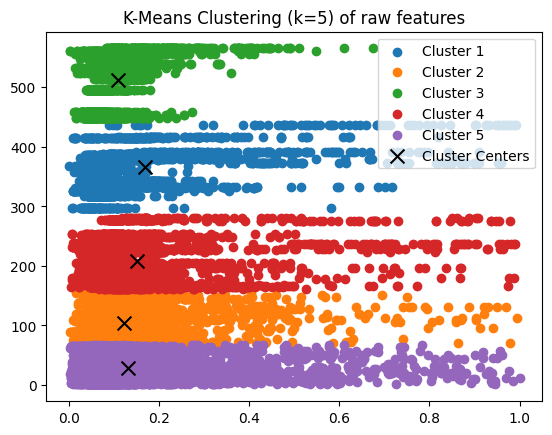

In [52]:
# Define the number of clusters (k) you want to find
k = 5

node_features = prod_features.detach().numpy()

# Apply K-Means clustering
kmeans = KMeans(n_clusters=k)
clusters = kmeans.fit_predict(node_features)

# Scatter plot the results
for cluster_id in range(k):
    plt.scatter(node_features[clusters == cluster_id, 0], node_features[clusters == cluster_id, 1], label=f'Cluster {cluster_id + 1}')

# Plot the cluster centers
cluster_centers = kmeans.cluster_centers_
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='x', color='black', s=100, label='Cluster Centers')

plt.title(f'K-Means Clustering (k={k}) of raw features')
plt.legend()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


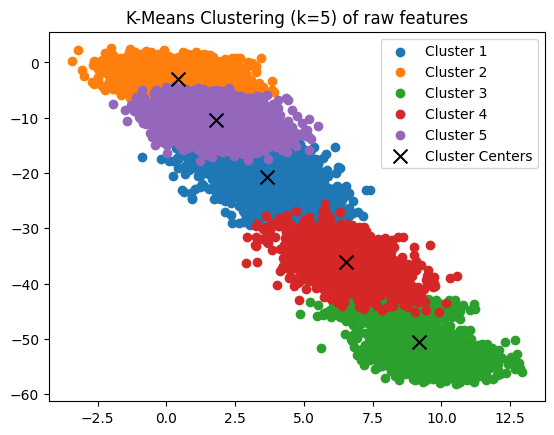

In [54]:
# Define the number of clusters (k) you want to find
k = 5

node_features = final_emb['product'].detach().numpy()

# Apply K-Means clustering
kmeans = KMeans(n_clusters=k)
clusters = kmeans.fit_predict(node_features)

# Scatter plot the results
for cluster_id in range(k):
    plt.scatter(node_features[clusters == cluster_id, 0], node_features[clusters == cluster_id, 1], label=f'Cluster {cluster_id + 1}')

# Plot the cluster centers
cluster_centers = kmeans.cluster_centers_
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='x', color='black', s=100, label='Cluster Centers')

plt.title(f'K-Means Clustering (k={k}) of raw features')
plt.legend()
plt.show()

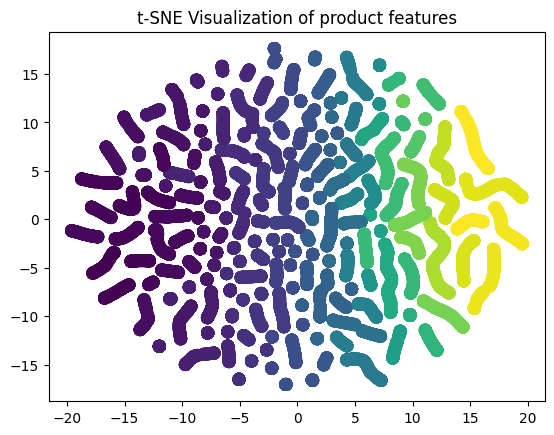

In [55]:
import matplotlib.pyplot as plt

# Perform dimensionality reduction using t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
embeddings_2d = tsne.fit_transform(prod_features.detach().numpy())

color = prod_features[:,1].detach().numpy()

plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=70, c=color)
plt.title('t-SNE Visualization of product features')
plt.show()

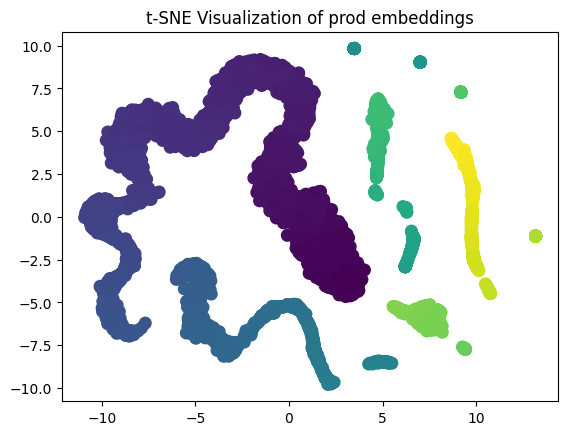

In [66]:
import matplotlib.pyplot as plt

# Perform dimensionality reduction using t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
embeddings_2d = tsne.fit_transform(final_emb['product'].detach().numpy())

color = final_data['product'].x[:,1].detach().numpy()

plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=70, c=color)
plt.title('t-SNE Visualization of prod embeddings')
plt.show()

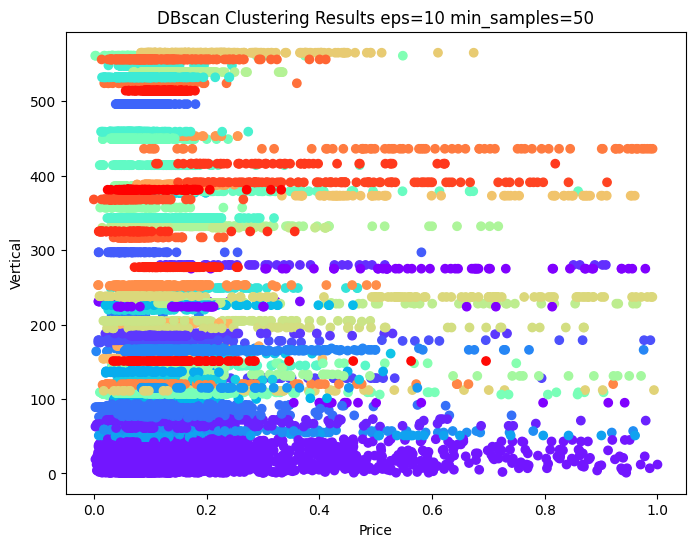

In [61]:
from sklearn.cluster import DBSCAN

# Create a DBSCAN model
dbscan = DBSCAN(eps=1.8, min_samples=50)
clusters = dbscan.fit_predict(prod_features.detach().numpy())

# Create a scatter plot for the clusters
plt.figure(figsize=(8, 6))
plt.scatter(prod_features[:,0].detach().numpy(), prod_features[:,1].detach().numpy(), c=clusters, cmap='rainbow')
plt.xlabel('Price')
plt.ylabel('Vertical')
plt.title('DBscan Clustering Results eps=10 min_samples=50')
plt.show()

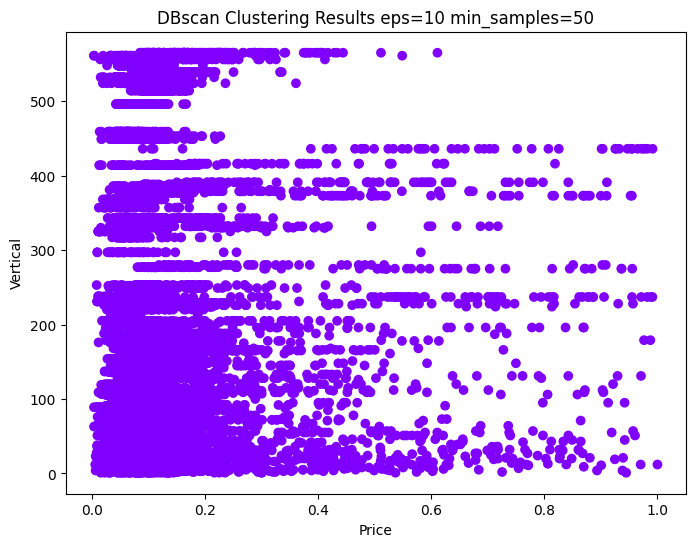

In [69]:
from sklearn.cluster import DBSCAN

# Create a DBSCAN model
dbscan = DBSCAN(eps=100, min_samples=200)
clusters = dbscan.fit_predict(final_emb['product'].detach().numpy())

# Create a scatter plot for the clusters
plt.figure(figsize=(8, 6))
plt.scatter(final_data['product'].x[:,0].detach().numpy(), final_data['product'].x[:,1].detach().numpy(), c=clusters, cmap='rainbow')
plt.xlabel('Price')
plt.ylabel('Vertical')
plt.title('DBscan Clustering Results eps=10 min_samples=50')
plt.show()